**# RESNET50 + D0**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
import torchvision
import torch.nn.functional as F
from torch import optim
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

**# Dataset Processing**

In [3]:
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=224, width=224),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=224, width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

train_image_path = '/content/drive/MyDrive/IP102/train' 
valid_image_path = '/content/drive/MyDrive/IP102/test' 
test_image_path = '/content/drive/MyDrive/IP102/val' 

train_image_paths = [] 
valid_image_paths = [] 
test_image_paths = [] 
classes = [] 

for train_image_path in glob.glob(train_image_path + '/*'):
    classes.append(train_image_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(train_image_path + '/*'))

for valid_image_path in glob.glob(valid_image_path + '/*'):
    valid_image_paths.append(glob.glob(valid_image_path + '/*'))

for test_image_path in glob.glob(test_image_path + '/*'):
    test_image_paths.append(glob.glob(test_image_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

valid_image_paths = list(flatten(valid_image_paths))
random.shuffle(valid_image_paths)

test_image_paths = list(flatten(test_image_paths))
random.shuffle(test_image_paths)


print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

class D0Dataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label
    
train_dataset = D0Dataset(train_image_paths,train_transforms)
valid_dataset = D0Dataset(valid_image_paths,test_transforms)
test_dataset = D0Dataset(test_image_paths,test_transforms)


train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False
)

Train size: 3950
Valid size: 1977
Test size: 658


# Visualize datasets

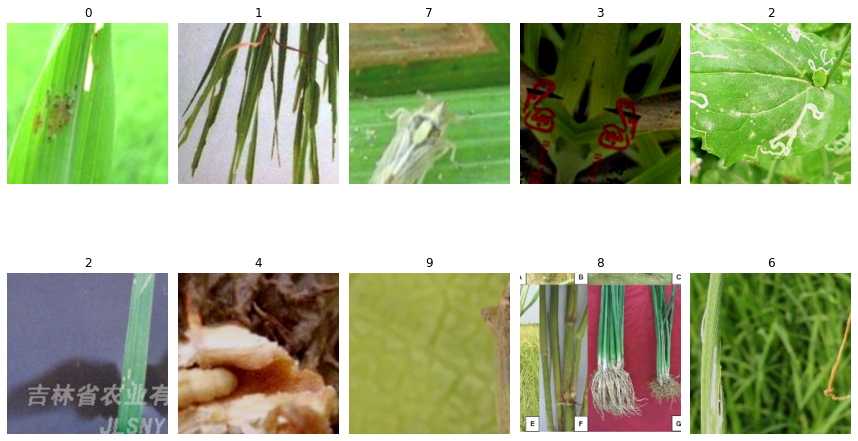

In [ ]:
%matplotlib inline

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

# **Define Model, Loss Function, Optimizer**

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(1024, 40)
)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# **Training and save Model**

In [ ]:
# Training Function 
train_model_training_loss_ls = []
train_model_training_accuracy_ls = []
validation_model_training_loss_ls = []
validation_model_training_accuracy_ls = [] 
best_accuracy = 0.0 

print("Begin training...") 
for epoch in range(1, 31): 
    running_train_loss = 0.0 
    running_accuracy = 0.0
    running_train_accuracy = 0.0  
    running_vall_loss = 0.0 
    val_total = 0
    train_total = 0 

    # Training Loop 
    for i, data in enumerate(train_loader, 0):
        inputs, outputs = data
        inputs, outputs = inputs.to(device), outputs.to(device)
        optimizer.zero_grad()          
        predicted_outputs = model(inputs)
        train_loss = loss_func(predicted_outputs, outputs)
        train_loss.backward()
        optimizer.step()
        running_train_loss +=train_loss.item()
        train_total += outputs.size(0)
        _, predicted = torch.max(predicted_outputs, 1) 
        running_train_accuracy += (predicted == outputs).sum().item()

              
    train_loss_value = running_train_loss/len(train_loader)
    train_accuracy = (running_train_accuracy / train_total)
    train_model_training_loss_ls.append(train_loss_value)
    train_model_training_accuracy_ls.append(train_accuracy)     
    with torch.no_grad(): 
        model.eval() 
        for data in valid_loader: 
            inputs, outputs = data 
            inputs, outputs = inputs.to(device), outputs.to(device)
            predicted_outputs = model(inputs) 
            val_loss = loss_func(predicted_outputs, outputs) 
          
            _, predicted = torch.max(predicted_outputs, 1) 
            running_vall_loss += val_loss.item()  
            val_total += outputs.size(0) 
            running_accuracy += (predicted == outputs).sum().item() 


    val_loss_value = running_vall_loss/len(valid_loader) 
    val_accuracy = (running_accuracy / val_total)     
    validation_model_training_loss_ls.append(val_loss_value)        
    validation_model_training_accuracy_ls.append(val_accuracy)
    if val_accuracy > best_accuracy: 
        PATH = '/content/drive/MyDrive/AI/V2_DenseNet121_IP102'
        torch.save(model.state_dict(), PATH) 
        best_accuracy = val_accuracy 
      
    print('Epoch', epoch, 'Training Loss: %.4f;' %train_loss_value, 'Validation Loss: %.4f;' %val_loss_value, 'Training Acccuracy: %.4f;' %train_accuracy, 'Validation Acccuracy: %.4f;' %val_accuracy)

Begin training...
Epoch 1 Training Loss: 4.3033; Validation Loss: 2.3778; Training Acccuracy: 0.1701; Validation Acccuracy: 0.2853;
Epoch 2 Training Loss: 2.4169; Validation Loss: 2.2759; Training Acccuracy: 0.1711; Validation Acccuracy: 0.1872;
Epoch 3 Training Loss: 2.2087; Validation Loss: 2.0738; Training Acccuracy: 0.2081; Validation Acccuracy: 0.2473;
Epoch 4 Training Loss: 2.0898; Validation Loss: 1.9614; Training Acccuracy: 0.2671; Validation Acccuracy: 0.3227;
Epoch 5 Training Loss: 2.0214; Validation Loss: 1.8506; Training Acccuracy: 0.2929; Validation Acccuracy: 0.3561;
Epoch 6 Training Loss: 1.9336; Validation Loss: 1.7209; Training Acccuracy: 0.3261; Validation Acccuracy: 0.4021;
Epoch 7 Training Loss: 1.8707; Validation Loss: 1.6440; Training Acccuracy: 0.3486; Validation Acccuracy: 0.4183;
Epoch 8 Training Loss: 1.7964; Validation Loss: 1.5672; Training Acccuracy: 0.3711; Validation Acccuracy: 0.4522;
Epoch 9 Training Loss: 1.7291; Validation Loss: 1.5289; Training Acccu

In [ ]:
print("Continue training...") 
for epoch in range(31, 51): 
    running_train_loss = 0.0 
    running_accuracy = 0.0
    running_train_accuracy = 0.0  
    running_vall_loss = 0.0 
    val_total = 0
    train_total = 0 

    # Training Loop 
    for i, data in enumerate(train_loader, 0):
        inputs, outputs = data
        inputs, outputs = inputs.to(device), outputs.to(device)
        optimizer.zero_grad()          
        predicted_outputs = model(inputs)
        train_loss = loss_func(predicted_outputs, outputs)
        train_loss.backward()
        optimizer.step()
        running_train_loss +=train_loss.item()
        train_total += outputs.size(0)
        _, predicted = torch.max(predicted_outputs, 1) 
        running_train_accuracy += (predicted == outputs).sum().item()

              
    train_loss_value = running_train_loss/len(train_loader)
    train_accuracy = (running_train_accuracy / train_total)
    train_model_training_loss_ls.append(train_loss_value)
    train_model_training_accuracy_ls.append(train_accuracy)     
    with torch.no_grad(): 
        model.eval() 
        for data in valid_loader: 
            inputs, outputs = data 
            inputs, outputs = inputs.to(device), outputs.to(device)
            predicted_outputs = model(inputs) 
            val_loss = loss_func(predicted_outputs, outputs) 
          
            _, predicted = torch.max(predicted_outputs, 1) 
            running_vall_loss += val_loss.item()  
            val_total += outputs.size(0) 
            running_accuracy += (predicted == outputs).sum().item() 


    val_loss_value = running_vall_loss/len(valid_loader) 
    val_accuracy = (running_accuracy / val_total)     
    validation_model_training_loss_ls.append(val_loss_value)        
    validation_model_training_accuracy_ls.append(val_accuracy)
    if val_accuracy > best_accuracy: 
        PATH = '/content/drive/MyDrive/AI/V2_DenseNet121_IP102'
        torch.save(model.state_dict(), PATH) 
        best_accuracy = val_accuracy 
      
    print('Epoch', epoch, 'Training Loss: %.4f;' %train_loss_value, 'Validation Loss: %.4f;' %val_loss_value, 'Training Acccuracy: %.4f;' %train_accuracy, 'Validation Acccuracy: %.4f;' %val_accuracy)

Continue training...
Epoch 31 Training Loss: 1.2405; Validation Loss: 1.2593; Training Acccuracy: 0.5666; Validation Acccuracy: 0.5867;
Epoch 32 Training Loss: 1.2414; Validation Loss: 1.2698; Training Acccuracy: 0.5537; Validation Acccuracy: 0.5928;
Epoch 33 Training Loss: 1.2183; Validation Loss: 1.3080; Training Acccuracy: 0.5653; Validation Acccuracy: 0.5847;
Epoch 34 Training Loss: 1.2077; Validation Loss: 1.3449; Training Acccuracy: 0.5772; Validation Acccuracy: 0.5761;
Epoch 35 Training Loss: 1.2026; Validation Loss: 1.2609; Training Acccuracy: 0.5747; Validation Acccuracy: 0.5953;
Epoch 36 Training Loss: 1.1936; Validation Loss: 1.2942; Training Acccuracy: 0.5787; Validation Acccuracy: 0.5787;
Epoch 37 Training Loss: 1.1904; Validation Loss: 1.2773; Training Acccuracy: 0.5924; Validation Acccuracy: 0.5751;
Epoch 38 Training Loss: 1.1884; Validation Loss: 1.2579; Training Acccuracy: 0.5808; Validation Acccuracy: 0.5898;
Epoch 39 Training Loss: 1.1430; Validation Loss: 1.3130; Tr

In [ ]:
print("Continue training...") 
for epoch in range(51, 71): 
    running_train_loss = 0.0 
    running_accuracy = 0.0
    running_train_accuracy = 0.0  
    running_vall_loss = 0.0 
    val_total = 0
    train_total = 0 

    # Training Loop 
    for i, data in enumerate(train_loader, 0):
        inputs, outputs = data
        inputs, outputs = inputs.to(device), outputs.to(device)
        optimizer.zero_grad()          
        predicted_outputs = model(inputs)
        train_loss = loss_func(predicted_outputs, outputs)
        train_loss.backward()
        optimizer.step()
        running_train_loss +=train_loss.item()
        train_total += outputs.size(0)
        _, predicted = torch.max(predicted_outputs, 1) 
        running_train_accuracy += (predicted == outputs).sum().item()

              
    train_loss_value = running_train_loss/len(train_loader)
    train_accuracy = (running_train_accuracy / train_total)
    train_model_training_loss_ls.append(train_loss_value)
    train_model_training_accuracy_ls.append(train_accuracy)     
    with torch.no_grad(): 
        model.eval() 
        for data in valid_loader: 
            inputs, outputs = data 
            inputs, outputs = inputs.to(device), outputs.to(device)
            predicted_outputs = model(inputs) 
            val_loss = loss_func(predicted_outputs, outputs) 
          
            _, predicted = torch.max(predicted_outputs, 1) 
            running_vall_loss += val_loss.item()  
            val_total += outputs.size(0) 
            running_accuracy += (predicted == outputs).sum().item() 


    val_loss_value = running_vall_loss/len(valid_loader) 
    val_accuracy = (running_accuracy / val_total)     
    validation_model_training_loss_ls.append(val_loss_value)        
    validation_model_training_accuracy_ls.append(val_accuracy)
    if val_accuracy > best_accuracy: 
        PATH = '/content/drive/MyDrive/AI/V2_DenseNet121_IP102'
        torch.save(model.state_dict(), PATH) 
        best_accuracy = val_accuracy 
      
    print('Epoch', epoch, 'Training Loss: %.4f;' %train_loss_value, 'Validation Loss: %.4f;' %val_loss_value, 'Training Acccuracy: %.4f;' %train_accuracy, 'Validation Acccuracy: %.4f;' %val_accuracy)

Continue training...
Epoch 51 Training Loss: 1.0312; Validation Loss: 1.2949; Training Acccuracy: 0.6294; Validation Acccuracy: 0.6070;
Epoch 52 Training Loss: 1.0170; Validation Loss: 1.3137; Training Acccuracy: 0.6385; Validation Acccuracy: 0.6014;
Epoch 53 Training Loss: 1.0169; Validation Loss: 1.2920; Training Acccuracy: 0.6372; Validation Acccuracy: 0.5999;
Epoch 54 Training Loss: 1.0404; Validation Loss: 1.2641; Training Acccuracy: 0.6410; Validation Acccuracy: 0.6156;
Epoch 55 Training Loss: 0.9985; Validation Loss: 1.3150; Training Acccuracy: 0.6456; Validation Acccuracy: 0.6050;
Epoch 56 Training Loss: 1.0086; Validation Loss: 1.2608; Training Acccuracy: 0.6372; Validation Acccuracy: 0.6242;
Epoch 57 Training Loss: 0.9951; Validation Loss: 1.3010; Training Acccuracy: 0.6415; Validation Acccuracy: 0.6181;
Epoch 58 Training Loss: 0.9900; Validation Loss: 1.3040; Training Acccuracy: 0.6506; Validation Acccuracy: 0.6065;
Epoch 59 Training Loss: 0.9952; Validation Loss: 1.3446; Tr

In [ ]:
print("Continue training...") 
for epoch in range(71, 91): 
    running_train_loss = 0.0 
    running_accuracy = 0.0
    running_train_accuracy = 0.0  
    running_vall_loss = 0.0 
    val_total = 0
    train_total = 0 

    # Training Loop 
    for i, data in enumerate(train_loader, 0):
        inputs, outputs = data
        inputs, outputs = inputs.to(device), outputs.to(device)
        optimizer.zero_grad()          
        predicted_outputs = model(inputs)
        train_loss = loss_func(predicted_outputs, outputs)
        train_loss.backward()
        optimizer.step()
        running_train_loss +=train_loss.item()
        train_total += outputs.size(0)
        _, predicted = torch.max(predicted_outputs, 1) 
        running_train_accuracy += (predicted == outputs).sum().item()

              
    train_loss_value = running_train_loss/len(train_loader)
    train_accuracy = (running_train_accuracy / train_total)
    train_model_training_loss_ls.append(train_loss_value)
    train_model_training_accuracy_ls.append(train_accuracy)     
    with torch.no_grad(): 
        model.eval() 
        for data in valid_loader: 
            inputs, outputs = data 
            inputs, outputs = inputs.to(device), outputs.to(device)
            predicted_outputs = model(inputs) 
            val_loss = loss_func(predicted_outputs, outputs) 
          
            _, predicted = torch.max(predicted_outputs, 1) 
            running_vall_loss += val_loss.item()  
            val_total += outputs.size(0) 
            running_accuracy += (predicted == outputs).sum().item() 


    val_loss_value = running_vall_loss/len(valid_loader) 
    val_accuracy = (running_accuracy / val_total)     
    validation_model_training_loss_ls.append(val_loss_value)        
    validation_model_training_accuracy_ls.append(val_accuracy)
    if val_accuracy > best_accuracy: 
        PATH = '/content/drive/MyDrive/AI/V2_DenseNet121_IP102'
        torch.save(model.state_dict(), PATH) 
        best_accuracy = val_accuracy 
      
    print('Epoch', epoch, 'Training Loss: %.4f;' %train_loss_value, 'Validation Loss: %.4f;' %val_loss_value, 'Training Acccuracy: %.4f;' %train_accuracy, 'Validation Acccuracy: %.4f;' %val_accuracy)

Continue training...
Epoch 71 Training Loss: 0.9113; Validation Loss: 1.3553; Training Acccuracy: 0.6757; Validation Acccuracy: 0.6141;
Epoch 72 Training Loss: 0.9038; Validation Loss: 1.3748; Training Acccuracy: 0.6868; Validation Acccuracy: 0.6131;
Epoch 73 Training Loss: 0.9054; Validation Loss: 1.3871; Training Acccuracy: 0.6782; Validation Acccuracy: 0.6267;
Epoch 74 Training Loss: 0.9242; Validation Loss: 1.3663; Training Acccuracy: 0.6767; Validation Acccuracy: 0.6039;
Epoch 75 Training Loss: 0.8844; Validation Loss: 1.4052; Training Acccuracy: 0.6891; Validation Acccuracy: 0.6287;
Epoch 76 Training Loss: 0.8752; Validation Loss: 1.3566; Training Acccuracy: 0.6896; Validation Acccuracy: 0.6232;
Epoch 77 Training Loss: 0.9150; Validation Loss: 1.2896; Training Acccuracy: 0.6815; Validation Acccuracy: 0.6318;
Epoch 78 Training Loss: 0.8922; Validation Loss: 1.3336; Training Acccuracy: 0.6856; Validation Acccuracy: 0.6166;
Epoch 79 Training Loss: 0.8856; Validation Loss: 1.3381; Tr

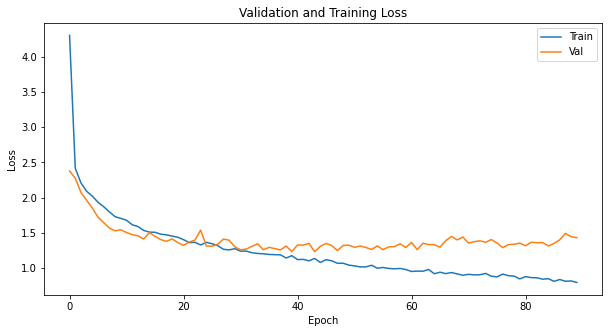

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation and Training Loss")
plt.plot(train_model_training_loss_ls,label="Train")
plt.plot(validation_model_training_loss_ls,label="Val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


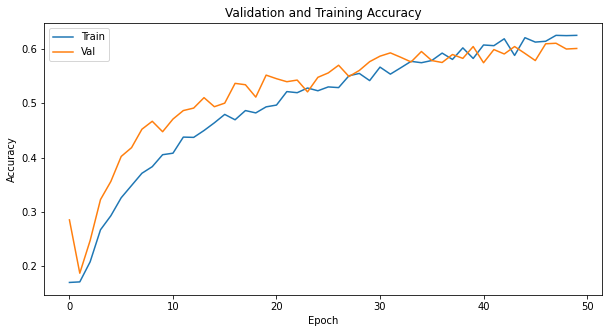

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation and Training Accuracy")
plt.plot(train_model_training_accuracy_ls,label="Train")
plt.plot(validation_model_training_accuracy_ls,label="Val")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(2048, 40)
)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# Training Function 
train_model_training_loss_ls = []
train_model_training_accuracy_ls = []
validation_model_training_loss_ls = []
validation_model_training_accuracy_ls = [] 
best_accuracy = 0.0 

print("Begin training...") 
for epoch in range(1, 91): 
    running_train_loss = 0.0 
    running_accuracy = 0.0
    running_train_accuracy = 0.0  
    running_vall_loss = 0.0 
    val_total = 0
    train_total = 0 

    # Training Loop 
    for i, data in enumerate(train_loader, 0):
        inputs, outputs = data
        inputs, outputs = inputs.to(device), outputs.to(device)
        optimizer.zero_grad()          
        predicted_outputs = model(inputs)
        train_loss = loss_func(predicted_outputs, outputs)
        train_loss.backward()
        optimizer.step()
        running_train_loss +=train_loss.item()
        train_total += outputs.size(0)
        _, predicted = torch.max(predicted_outputs, 1) 
        running_train_accuracy += (predicted == outputs).sum().item()

              
    train_loss_value = running_train_loss/len(train_loader)
    train_accuracy = (running_train_accuracy / train_total)
    train_model_training_loss_ls.append(train_loss_value)
    train_model_training_accuracy_ls.append(train_accuracy)     
    with torch.no_grad(): 
        model.eval() 
        for data in valid_loader: 
            inputs, outputs = data 
            inputs, outputs = inputs.to(device), outputs.to(device)
            predicted_outputs = model(inputs) 
            val_loss = loss_func(predicted_outputs, outputs) 
          
            _, predicted = torch.max(predicted_outputs, 1) 
            running_vall_loss += val_loss.item()  
            val_total += outputs.size(0) 
            running_accuracy += (predicted == outputs).sum().item() 


    val_loss_value = running_vall_loss/len(valid_loader) 
    val_accuracy = (running_accuracy / val_total)     
    validation_model_training_loss_ls.append(val_loss_value)        
    validation_model_training_accuracy_ls.append(val_accuracy)
    if val_accuracy > best_accuracy: 
        PATH = '/content/drive/MyDrive/AI/V2_WideResNet502_IP102'
        torch.save(model.state_dict(), PATH) 
        best_accuracy = val_accuracy 
      
    print('Epoch', epoch, 'Training Loss: %.4f;' %train_loss_value, 'Validation Loss: %.4f;' %val_loss_value, 'Training Acccuracy: %.4f;' %train_accuracy, 'Validation Acccuracy: %.4f;' %val_accuracy)

Begin training...
Epoch 1 Training Loss: 2.5087; Validation Loss: 2.1317; Training Acccuracy: 0.1937; Validation Acccuracy: 0.2767;
Epoch 2 Training Loss: 2.0561; Validation Loss: 1.8009; Training Acccuracy: 0.2828; Validation Acccuracy: 0.3692;
Epoch 3 Training Loss: 1.8365; Validation Loss: 1.5868; Training Acccuracy: 0.3585; Validation Acccuracy: 0.4203;
Epoch 4 Training Loss: 1.6992; Validation Loss: 1.4787; Training Acccuracy: 0.4063; Validation Acccuracy: 0.4765;
Epoch 5 Training Loss: 1.6236; Validation Loss: 1.4761; Training Acccuracy: 0.4253; Validation Acccuracy: 0.4669;
Epoch 6 Training Loss: 1.5604; Validation Loss: 1.3636; Training Acccuracy: 0.4395; Validation Acccuracy: 0.5043;
Epoch 7 Training Loss: 1.4905; Validation Loss: 1.3470; Training Acccuracy: 0.4641; Validation Acccuracy: 0.5225;
Epoch 8 Training Loss: 1.4634; Validation Loss: 1.3492; Training Acccuracy: 0.4823; Validation Acccuracy: 0.5326;
Epoch 9 Training Loss: 1.4104; Validation Loss: 1.3286; Training Acccu

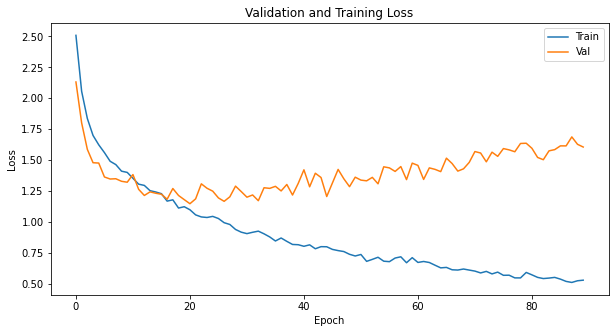

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation and Training Loss")
plt.plot(train_model_training_loss_ls,label="Train")
plt.plot(validation_model_training_loss_ls,label="Val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


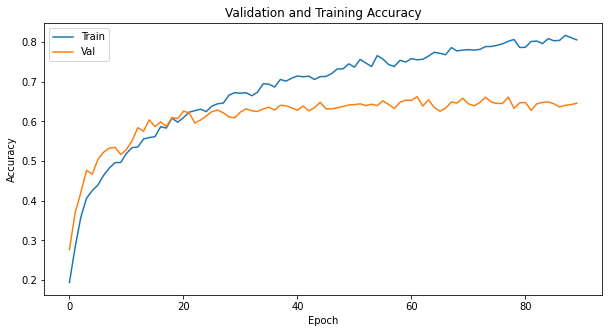

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation and Training Accuracy")
plt.plot(train_model_training_accuracy_ls,label="Train")
plt.plot(validation_model_training_accuracy_ls,label="Val")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 40)
)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Training Function 
train_model_training_loss_ls = []
train_model_training_accuracy_ls = []
validation_model_training_loss_ls = []
validation_model_training_accuracy_ls = [] 
best_accuracy = 0.0 

print("Begin training...") 
for epoch in range(1, 91): 
    running_train_loss = 0.0 
    running_accuracy = 0.0
    running_train_accuracy = 0.0  
    running_vall_loss = 0.0 
    val_total = 0
    train_total = 0 

    # Training Loop 
    for i, data in enumerate(train_loader, 0):
        inputs, outputs = data
        inputs, outputs = inputs.to(device), outputs.to(device)
        optimizer.zero_grad()          
        predicted_outputs = model(inputs)
        train_loss = loss_func(predicted_outputs, outputs)
        train_loss.backward()
        optimizer.step()
        running_train_loss +=train_loss.item()
        train_total += outputs.size(0)
        _, predicted = torch.max(predicted_outputs, 1) 
        running_train_accuracy += (predicted == outputs).sum().item()

              
    train_loss_value = running_train_loss/len(train_loader)
    train_accuracy = (running_train_accuracy / train_total)
    train_model_training_loss_ls.append(train_loss_value)
    train_model_training_accuracy_ls.append(train_accuracy)     
    with torch.no_grad(): 
        model.eval() 
        for data in valid_loader: 
            inputs, outputs = data 
            inputs, outputs = inputs.to(device), outputs.to(device)
            predicted_outputs = model(inputs) 
            val_loss = loss_func(predicted_outputs, outputs) 
          
            _, predicted = torch.max(predicted_outputs, 1) 
            running_vall_loss += val_loss.item()  
            val_total += outputs.size(0) 
            running_accuracy += (predicted == outputs).sum().item() 


    val_loss_value = running_vall_loss/len(valid_loader) 
    val_accuracy = (running_accuracy / val_total)     
    validation_model_training_loss_ls.append(val_loss_value)        
    validation_model_training_accuracy_ls.append(val_accuracy)
    if val_accuracy > best_accuracy: 
        PATH = '/content/drive/MyDrive/AI/V2_ResNet50_IP1022'
        torch.save(model.state_dict(), PATH) 
        best_accuracy = val_accuracy 
      
    print('Epoch', epoch, 'Training Loss: %.4f;' %train_loss_value, 'Validation Loss: %.4f;' %val_loss_value, 'Training Acccuracy: %.4f;' %train_accuracy, 'Validation Acccuracy: %.4f;' %val_accuracy)

Begin training...
Epoch 1 Training Loss: 2.4050; Validation Loss: 2.0328; Training Acccuracy: 0.2071; Validation Acccuracy: 0.3187;
Epoch 2 Training Loss: 1.9642; Validation Loss: 1.7836; Training Acccuracy: 0.3139; Validation Acccuracy: 0.3905;
Epoch 3 Training Loss: 1.8184; Validation Loss: 1.5574; Training Acccuracy: 0.3587; Validation Acccuracy: 0.4234;
Epoch 4 Training Loss: 1.7404; Validation Loss: 1.5208; Training Acccuracy: 0.3884; Validation Acccuracy: 0.4694;
Epoch 5 Training Loss: 1.6777; Validation Loss: 1.4317; Training Acccuracy: 0.4129; Validation Acccuracy: 0.5008;
Epoch 6 Training Loss: 1.6010; Validation Loss: 1.3965; Training Acccuracy: 0.4299; Validation Acccuracy: 0.5094;
Epoch 7 Training Loss: 1.5568; Validation Loss: 1.3981; Training Acccuracy: 0.4456; Validation Acccuracy: 0.5250;
Epoch 8 Training Loss: 1.4849; Validation Loss: 1.4412; Training Acccuracy: 0.4641; Validation Acccuracy: 0.5048;
Epoch 9 Training Loss: 1.4797; Validation Loss: 1.3719; Training Acccu

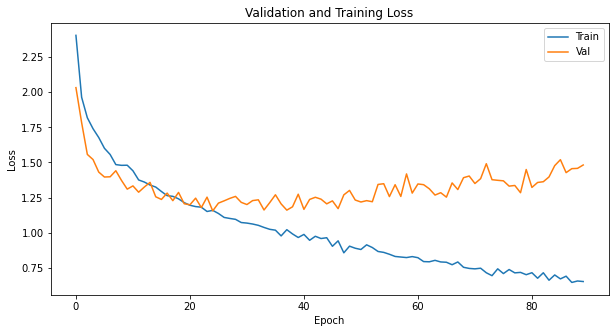

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation and Training Loss")
plt.plot(train_model_training_loss_ls,label="Train")
plt.plot(validation_model_training_loss_ls,label="Val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

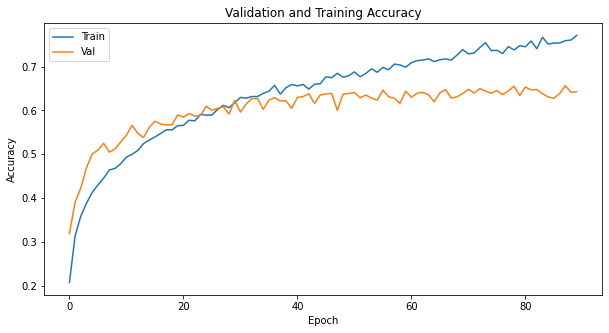

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation and Training Accuracy")
plt.plot(train_model_training_accuracy_ls,label="Train")
plt.plot(validation_model_training_accuracy_ls,label="Val")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# **Load Model and Testing**

In [5]:
PATH = '/content/drive/MyDrive/AI/V2_ResNet50_IP102'
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 40)
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load(PATH))
model = model.to(device)
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the total test images: {100 * correct // total} %')


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Accuracy of the network on the total test images: 60 %


In [7]:
PATH = '/content/drive/MyDrive/AI/V2_WideResNet_50_2_IP102'
model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet101_2', pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(2048, 40)
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load(PATH))
model = model.to(device)
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the total test images: {100 * correct // total} %')


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet101_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet101_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth


  0%|          | 0.00/243M [00:00<?, ?B/s]

Accuracy of the network on the total test images: 59 %


In [11]:
PATH = '/content/drive/MyDrive/AI/V2_DenseNet121_IP102'
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(1024, 40)
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load(PATH))
model = model.to(device)
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the total test images: {100 * correct // total} %')


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Accuracy of the network on the total test images: 8 %
